In [1]:
# mengimportkan berbagai library yang di perlukan untuk memanipulasi
# gambar, pemrosesan data, pembuatan model, visualisasi, dan evaluasi model.

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pickle
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# import shutil
# from sklearn.utils import resample
# import seaborn as sns


In [2]:
# membuat definisi fungsi untuk memuat dan memproses gambar

img_width, img_height = 128, 128
img_size= (img_width, img_height)

In [3]:
# Fungsi untuk memuat dan memproses gambar dengan mengubah ukurannya
# dan menormalkan nilainya

def load_and_preprocess_image(image_path, img_size=(img_width, img_height)):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, img_size)
    img_array = img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [4]:
# Fungsi untuk mengekstrak fitur menggunakan VGG16
def extract_features(model, image_path, img_size):
    img_array = load_and_preprocess_image(image_path, img_size)
    features = model.predict(img_array)
    return features.flatten()



In [5]:
# memuat dataset dan mengektraski fitur

base_dir = "D:\\penelitian arya\\dataset penelitian\\Train"
img_size = (img_width, img_height) 

# Memuat model VGG16 pra-terlatih
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor= Model(inputs=base_model.input, outputs=base_model.output)

In [6]:
# Memuat dan mengekstraksi fitur dari dataset
features = []
labels = []

for label in os.listdir(base_dir):
    label_folder = os.path.join(base_dir, label)
    if os.path.isdir(label_folder):
        for filename in os.listdir(label_folder):
            image_path = os.path.join(label_folder, filename)
            feature = extract_features(feature_extractor, image_path, img_size)
            features.append(feature)
            labels.append(label)

features = np.array(features)
labels = np.array(labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

In [7]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


# Reduksi dimensi menggunakan PCA untuk mengurangi kompleksitas
# fitur.

pca = PCA(n_components= 50)  # pengurangan 
features_pca = pca.fit_transform(features)

In [8]:
# Membagi dataset menjadi data latih dan validasi
train_split = 0.8
X_train, X_valid, y_train, y_valid = train_test_split(features_pca, labels_encoded, 
                                                      train_size=train_split, shuffle=True, 
                                                      random_state=123)

In [9]:
# menentukan parameter grid untuk knn
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Melakukan Grid Search untuk mencari parameter terbaik
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3}


In [10]:
# Melatih model KNN
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)


KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [11]:
# Menyimpan model yang sudah dilatih, PCA, dan label encoder yang 
# sudah dilatih kedalam file

model_path = "knn_model_vgg16&PCA.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(best_knn, file)
    pickle.dump(pca, file)
    pickle.dump(label_encoder, file)

In [12]:
# Menguji model dan mengevaluasi kinerja
y_pred = best_knn.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f'Akurasi: {accuracy * 100:.2f}%')

Akurasi: 81.19%


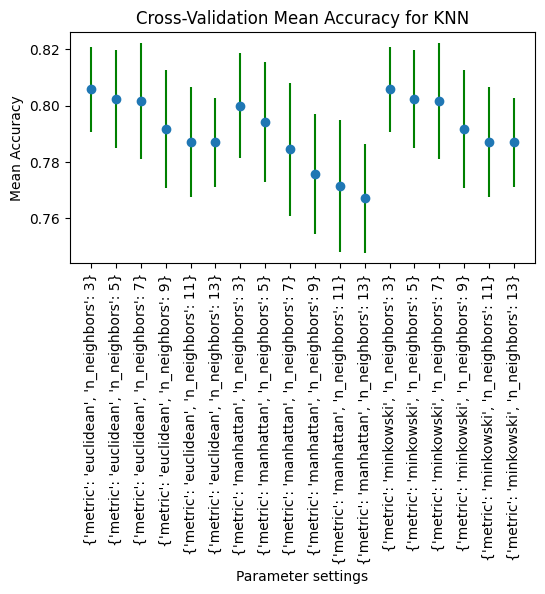

In [13]:
# Fungsi untuk menampilkan grafik akurasi KNN selama cross-validation
def plot_knn_cross_validation(cv_results):
    mean_test_scores = cv_results['mean_test_score']
    std_test_scores = cv_results['std_test_score']
    params = [str(params) for params in cv_results['params']]
    
    plt.figure(figsize=(6, 3))
    plt.errorbar(range(len(params)), mean_test_scores, yerr=std_test_scores, fmt='o', ecolor='g', capthick=2)
    plt.xticks(range(len(params)), params, rotation=90)
    plt.xlabel('Parameter settings')
    plt.ylabel('Mean Accuracy')
    plt.title('Cross-Validation Mean Accuracy for KNN')
    plt.show()

# Memanggil fungsi untuk menampilkan grafik
plot_knn_cross_validation(grid_search.cv_results_)


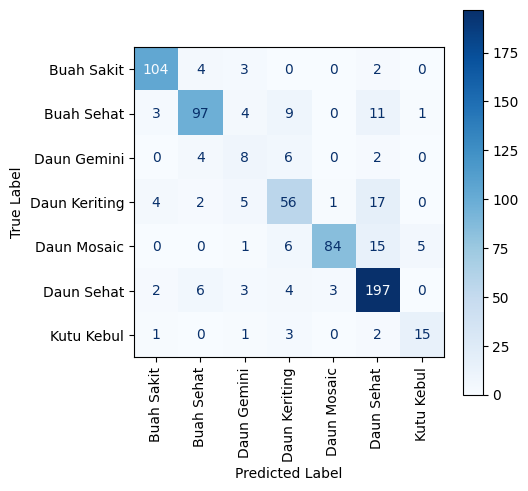

Confusion Matrix
[[104   4   3   0   0   2   0]
 [  3  97   4   9   0  11   1]
 [  0   4   8   6   0   2   0]
 [  4   2   5  56   1  17   0]
 [  0   0   1   6  84  15   5]
 [  2   6   3   4   3 197   0]
 [  1   0   1   3   0   2  15]]
Classification Report
               precision    recall  f1-score   support

   Buah Sakit       0.91      0.92      0.92       113
   Buah Sehat       0.86      0.78      0.82       125
  Daun Gemini       0.32      0.40      0.36        20
Daun Keriting       0.67      0.66      0.66        85
  Daun Mosaic       0.95      0.76      0.84       111
   Daun Sehat       0.80      0.92      0.85       215
   Kutu Kebul       0.71      0.68      0.70        22

     accuracy                           0.81       691
    macro avg       0.75      0.73      0.74       691
 weighted avg       0.82      0.81      0.81       691

Precision: 0.8210
Recall: 0.8119
F1-Score: 0.8129


In [22]:
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Confusion Matrix
print('Confusion Matrix')
print(cm)

# Classification Report
report = classification_report(y_valid, y_pred, target_names=label_encoder.classes_)
print('Classification Report')
print(report)

# Precision, Recall, F1-Score
precision = precision_score(y_valid, y_pred, average='weighted')
recall = recall_score(y_valid, y_pred, average='weighted')
f1 = f1_score(y_valid, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [14]:
# # Menampilkan Confusion Matrix 
# cm = confusion_matrix(y_valid, y_pred, labels=best_knn.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical') # coba ganti vertikal menjadi horizontal, lihat perbedaan pada grafik
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # Confusion Matrix
# print('Confusion Matrix')
# cm = confusion_matrix(y_valid, y_pred)
# print(cm)

# # classification report
# report = classification_report(y_valid, y_pred, target_names=label_encoder.classes_)
# print('Classification Report')
# print(report)

# # Precision, Recall, F1-Score
# precision = precision_score(y_valid, y_pred, average='weighted')
# recall = recall_score(y_valid, y_pred, average='weighted')
# f1 = f1_score(y_valid, y_pred, average='weighted')

# print(f'Precision: {precision:.4f}')
# print(f'Recall: {recall:.4f}')
# print(f'F1-Score: {f1:.4f}')



In [15]:
# Fungsi untuk mendapatkan probabilitas prediksi dari gambar yang dikenal
# def get_probabilities(folder_path, knn_model, feature_extractor, pca_model, img_size=(128, 128)):
#     probabilities = []
#     for filename in os.listdir(folder_path):
#         if filename.endswith(('.jpeg', '.png', '.jpg')):
#             image_path = os.path.join(folder_path, filename)
#             features = extract_features(feature_extractor, image_path, img_size)
#             features_pca = pca_model.transform(features.reshape(1, -1))
#             prob = np.max(knn_model.predict_proba(features_pca))
#             probabilities.append(prob)
#     return probabilities

# # Path ke folder gambar tes yang dikenal
# known_test_folder_path = r'D:\penelitian arya\Tes\tes yang dikenal'

# # Mengumpulkan probabilitas untuk gambar yang dikenal
# known_probabilities = get_probabilities(known_test_folder_path, best_knn, feature_extractor, pca, img_size=(128, 128))

# # Path ke folder gambar tes yang tidak dikenal
# unknown_test_folder_path = r'D:\penelitian arya\Tes\tes yang tidak dikenal'

# # Mengumpulkan probabilitas untuk gambar yang tidak dikenal
# unknown_probabilities = get_probabilities(unknown_test_folder_path, best_knn, feature_extractor, pca, img_size=(128, 128))

# # Menyeimbangkan jumlah gambar dengan undersampling
# # min_samples = min(len(known_probabilities), len(unknown_probabilities))
# # known_probabilities_resampled = resample(known_probabilities, replace=False, n_samples=min_samples, random_state=123)
# # unknown_probabilities_resampled = resample(unknown_probabilities, replace=False, n_samples=min_samples, random_state=123)

# # Plot distribusi probabilitas
# plt.figure(figsize=(6, 6))
# plt.hist(known_probabilities, bins=50, alpha=0.5, label='dikenal')
# plt.hist(unknown_probabilities, bins=50, alpha=0.5, label='tidak dikenal')
# plt.xlabel('Probability')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')
# plt.title('Distribution of Prediction Probabilities')
# plt.show()

# # Menentukan ambang batas optimal berdasarkan analisis distribusi
# optimal_threshold = 0.7  # Contoh ambang batas yang didapat dari analisis distribusi


In [16]:
# Menggabungkan probabilitas dan label untuk known dan unknown
# all_probabilities = np.concatenate((known_probabilities_resampled, unknown_probabilities_resampled))
# all_labels = np.concatenate((np.ones(len(known_probabilities_resampled)), np.zeros(len(unknown_probabilities_resampled))))

# # Menghitung ROC Curve
# fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)

# # Menghitung AUC
# roc_auc = auc(fpr, tpr)

# # Plot ROC Curve
# plt.figure(figsize=(5, 5))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

# # Menemukan threshold optimal
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# print(f"Optimal Threshold: {optimal_threshold}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


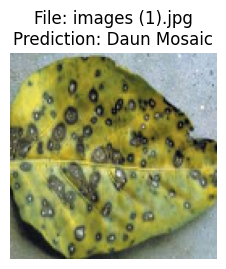

In [17]:
# Fungsi untuk memprediksi gambar dan menampilkannya
def predict_and_show_images_in_folder(folder_path, knn_model, feature_extractor, pca_model, label_encoder, img_size=(128, 128)):
    try:
        # Mendapatkan daftar file gambar
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpeg', '.png', '.jpg'))]
        num_images = len(image_files)
        num_columns = 4
        num_rows = num_images // num_columns + (num_images % num_columns != 0)
        
        plt.figure(figsize=(9, num_rows * 4))
        
        for i, filename in enumerate(image_files):
            image_path = os.path.join(folder_path, filename)
            features = extract_features(feature_extractor, image_path, img_size)
            # features = features.reshape(1, -1)
            features_pca = pca_model.transform(features.reshape(1, -1))
            
            # # Melakukan prediksi probabilitas
            # probabilities = knn_model.predict_proba(features_pca)
            # max_prob = np.max(probabilities)
            # predicted_class = np.argmax(probabilities)
            
            # # Tentukan hasil berdasarkan ambang batas kepercayaan
            # if max_prob < threshold:
            #     result = "Tidak Dikenal"
            # else:
            #     result = label_encoder.inverse_transform([predicted_class])[0]


            # # Melakukan prediksi
            prediction = knn_model.predict(features_pca)
            # predicted_class_index = int(prediction[0])
            result = label_encoder.inverse_transform(prediction)[0]

            # Menampilkan gambar dengan prediksi
            img = cv2.cvtColor(cv2.resize(cv2.imread(image_path), img_size), cv2.COLOR_BGR2RGB)
            
            plt.subplot(num_rows, num_columns, i + 1)
            plt.imshow(img)
            plt.title(f'File: {filename}\nPrediction: {result}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Path ke folder gambar tes 
test_folder_path = r'D:\penelitian arya\Tes\tes7'
img_width, img_height = 128, 128# Ukuran gambar yang sesuai dengan pelatihan
img_size = (img_width, img_height)

# # Memuat model KNN 
model_path = r'D:\penelitian arya\knn_model_vgg16&PCA.pkl'
with open(model_path, 'rb') as file:
    loaded_knn = pickle.load(file)
    loaded_pca = pickle.load(file)
    loaded_label_encoder = pickle.load(file)


# Memuat model VGG16 pra-terlatih
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Daftar label kelas
class_labels = ['Buah Sakit', 'Buah Sehat', 'Sakit Virus Gemini', 'Sakit Daun Keriting',
                'Sakit Daun Mosaic', 'Daun Sehat', 'Hama Kutu Kebul']

# Memanggil fungsi predict_and_show_images_in_folder
# optimal_threshold = 0.7
predict_and_show_images_in_folder(test_folder_path, loaded_knn, feature_extractor, loaded_pca, loaded_label_encoder, img_size=(128, 128))

In [18]:
# Fungsi predict_and_show_images_in_folder digunakan untuk memprediksi kelas 
# dari gambar-gambar dalam folder tertentu dan menampilkan hasilnya dalam grid.
# Memuat model KNN, PCA, dan label encoder yang telah disimpan.
# Menggunakan model VGG16 untuk mengekstraksi fitur dari gambar dalam folder tes.
# Menampilkan hasil prediksi untuk setiap gambar dalam folder tes.